In [33]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy import fftpack
import pyBigWig as pbw
from spectrum import pdaniell
from statsmodels.tsa.filters.filtertools import recursive_filter
from scipy.signal import detrend , periodogram
#from wps_spacing import daniell_spectrum as ds1

In [113]:
def read_bw(coordinate):
    chrom, coordinate = coordinate.split(':')
    start, end = map(lambda x: long(x),coordinate.split('-'))
    start, end = start, end
    bw_path ='/stor/work/Lambowitz/cdw2854/plasmaDNA/genomeWPS/bigWig_files'
    bw_file = pbw.open(bw_path + '/P1203_SQ2_S3_clustered.%s.Long.bigWig' %(chrom))
    #bw_file = pbw.open(bw_path + '/PD_1022_merged.%s.Long.bigWig' %(chrom))
    bw_file2 = pbw.open(bw_path + '/SRR2130052.%s.Long.bigWig' %(chrom))
    return np.array(bw_file.values(chrom, start, end)), \
            np.array(bw_file2.values(chrom, start, end))    

def shift_array(signal):
    signal = np.array(signal)
    signal = np.append(signal[:300], signal)
    return signal

filter_freq = 1.0/np.arange(5,100,4)
def re_filt(signal):
    signal = shift_array(signal)
    filter_length = len(filter_freq)
    signal = recursive_filter(signal, filter_freq)[300:]
    return signal

def demean(arr):
    return arr-arr.mean()

def weighted_smooth(w):                        
        def smoothing(arr):
            return (arr*w).mean()
        return smoothing


def daniell_smoother(arr):
    arr = pd.Series(arr)\
        .rolling(window = 3)\
        .apply(weighted_smooth(np.array([1,1,0.5])))
    return arr


def daniell_spectrum(signal):
    filtered_signal = re_filt(signal)
    filtered_signal = detrend(filtered_signal, type='linear')
    filtered_signal = demean(filtered_signal)
    # detrending and smoothing before spectrogram
    freq, psd = periodogram(filtered_signal, detrend='linear')
    psd = daniell_smoother(psd)
    #psd = 10 * np.log10(psd)
    return 1/freq, psd

In [114]:
coordinate = '10:122954381-122997513' #-982093'
wps1, wps2 = read_bw(coordinate)

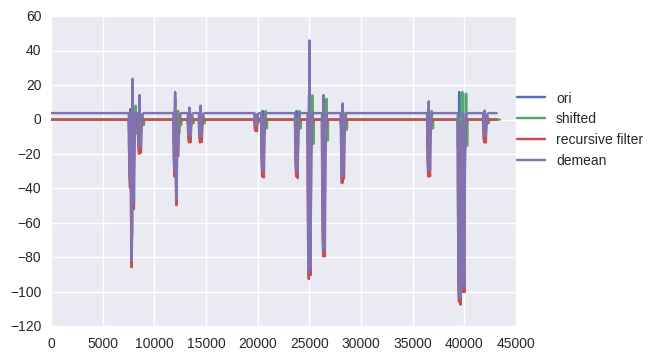

In [115]:
plt.plot(wps1, label='ori')
plt.plot(shift_array(wps1),label='shifted')
plt.plot(re_filt(wps1), label='recursive filter')
plt.plot(demean(re_filt(wps1)),label='demean')
plt.legend(bbox_to_anchor=(1.3,0.8))

In [ ]:
period1, intense1 = highest_periodicity(wps1)
period2, intense2 = highest_periodicity(wps2)
plt.subplot(231)
plt.plot(period1, intense1,label='original')
plt.title('PD')
plt.subplot(232)
plt.plot(period2, intense2,label='original')
plt.title('SRR')
plt.tight_layout()